#FashionMNIST by FaszynIsMyPaszyn

##Setup

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ustawiamy device jako `cuda` jesli udało nam się połączyć do GPU (co nie zawsze jest możliwe), natomiast jeśli się nie udało to naszym device będzie `cpu`.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Ponieważ pracujemy w notebooku online, a sesja  wyłącza się po jakimś czasie wczytywanie danych musi wyglądać w naszym przypadku tak, że każdorazowo pobieramy dane z Kaggle'a i tworzymy `pd.DataFrame df` z odpowiednich plików, które pobraliśmy.

##1. Wczytywanie danych

Dataset: https://www.kaggle.com/datasets/zalando-research/fashionmnist

Dataset składa się z 70 tysięcy zdjęć (10 tys na test i 60 tys na train), każde o rozmiarze `28x28` pixeli. Obraz jest reprezentowany jako wektor o rozmiarze `1x784` + 1 kolumna na label (liczba od 0 do 9), co finalnie daje DataFrame o rozmiarze `70000x785`.

W datasetcie mamy 10 następujących klas:

  0. T-shirt/top
  1. Trouser
  2. Pullover
  3. Dress
  4. Coat
  5. Sandal
  6. Shirt
  7. Sneaker
  8. Bag
  9. Ankle boot


 Przykładowe zdjęcia z datasetu są umieszczone poniżej.

###1.1 Pobieranie danych

Do pobrania danych korzystamy z modułu `kagglehub`,  dzięki któremu możemy szybko pobrać wszystkie dane.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Pobieramy dataset z Kaggla
path = kagglehub.dataset_download("zalando-research/fashionmnist")
train_path = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
test_path = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"
# Tworzymy DF
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###1.2 Tworzenie DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FashionSet(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.y = torch.tensor(df["label"].values, dtype=torch.long) # etykiety jako tensory
    imgs = df.drop(columns=["label"]).values.astype(np.float32) / 255.0
    self.X = torch.tensor(imgs).view(-1, 1, 28, 28) # N obrazków, 1 kanał, 28x28 -> tensory

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_ds = FashionSet(df_train)
test_ds = FashionSet(df_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [ ]:
class_names = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",3: "Dress",4: "Coat",5: "Sandal",6: "Shirt",7: "Sneaker",8: "Bag",9: "Ankle boot"}

###1.3 Wizualizacja obrazów

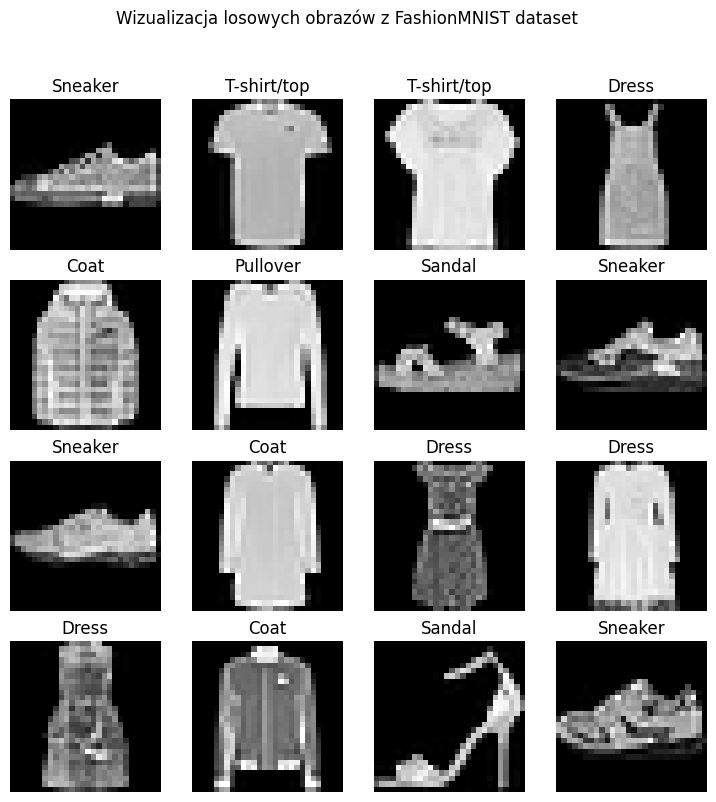

In [ ]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_ds), size=[1]).item()
  img, label = train_ds[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[int(label)])
  plt.axis(False)
plt.suptitle("Wizualizacja losowych obrazów z FashionMNIST dataset");

## 2. Model

###2.1 Tworzenie modelu

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1), #1 kanał (skala szarości) -> 32 mapy cech, kernel 3x3, padding=1, 28x28 -> 28x28
        nn.ReLU(), # max(0, x) - wprowadzenie nieliniowości
        nn.MaxPool2d(2), #max z każdego bloku 2x2: 28x28 -> 14x14
        nn.Conv2d(32, 64, 3, padding=1), #32 -> 64 kanały, kernel 3x3, padding=1, 14x14 -> 14x14
        nn.ReLU(), # max(0, x)
        nn.MaxPool2d(2), #14x14 -> 7x7
        nn.Flatten(), # 64 kanały * 7 * 7 pikseli -> wektor 3136 liczb
        nn.Linear(64*7*7, 128), # 3136 -> 128
        nn.ReLU(),
        nn.Dropout(p=0.3), #losowe zerowanie neuronów, spowolnienie overfittingu
        nn.Linear(128, 10) # 128 -> 10 klas
    )

  def forward(self, x):
    return self.cnn(x)

net = FashionCNN().to(device)
print(net)

FashionCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


###2.2 Wizualizacja modelu

Do wizualizacji modelu korzystamy z funkcji `draw_graph()` z modułu `torchview` z GitHub: https://github.com/mert-kurttutan/torchview

In [ ]:
!pip install torchview
import torchvision
from torchview import draw_graph

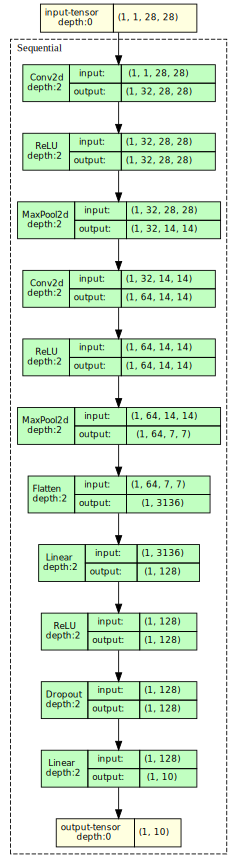

In [ ]:
model_graph = draw_graph(net, input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph

##3. Training loop

Funkcja straty: `nn.CrossEntropyLoss()`

Optimalizator: `optim.Adam()`

In [ ]:
from torch import optim

criterion = nn.CrossEntropyLoss() #funkcja straty
opt = optim.Adam(net.parameters(), lr=0.0001) #optymalizator

def epoch_pass(model, loader, train: bool = True):
  if train:
    model.train()
  else:
    model.eval()
  total_loss, correct, n = 0.0, 0.0, 0

  with torch.set_grad_enabled(train):
    for X, y in loader:
      X, y = X.to(device), y.to(device)

      if train:
        opt.zero_grad()

      out = model(X)
      loss = criterion(out, y)

      if train:
        loss.backward()
        opt.step()

      total_loss += loss.item() * y.size(0)
      correct += (out.argmax(1) == y).sum().item()
      n += y.size(0)

  return total_loss / n, correct / n

In [ ]:
EPOCHS = 100
tr_loss_res = []
tr_acc_res=[]
te_loss_res=[]
te_acc_res=[]
for ep in range(1, EPOCHS + 1):
  tr_loss, tr_acc = epoch_pass(net, train_loader, train=True)
  te_loss, te_acc = epoch_pass(net, test_loader, train=False)
  tr_loss_res.append(tr_loss)
  tr_acc_res.append(tr_acc)
  te_loss_res.append(te_loss)
  te_acc_res.append(te_acc)

  print(f"[{ep:02d}/{EPOCHS}] "
  f"train: loss={tr_loss:.4f} acc={tr_acc*100:.2f}% | "
  f"test: loss={te_loss:.4f} acc={te_acc*100:.2f}%")

[01/100] train: loss=0.9835 acc=67.44% | test: loss=0.5653 acc=79.77%
[02/100] train: loss=0.5582 acc=79.42% | test: loss=0.4698 acc=83.67%
[03/100] train: loss=0.4845 acc=82.53% | test: loss=0.4182 acc=85.07%
[04/100] train: loss=0.4375 acc=84.34% | test: loss=0.3824 acc=86.43%
[05/100] train: loss=0.4054 acc=85.51% | test: loss=0.3572 acc=87.35%
[06/100] train: loss=0.3843 acc=86.23% | test: loss=0.3422 acc=87.55%
[07/100] train: loss=0.3663 acc=86.78% | test: loss=0.3275 acc=88.26%
[08/100] train: loss=0.3532 acc=87.41% | test: loss=0.3168 acc=88.51%
[09/100] train: loss=0.3402 acc=87.78% | test: loss=0.3062 acc=88.79%
[10/100] train: loss=0.3317 acc=88.12% | test: loss=0.2987 acc=89.24%
[11/100] train: loss=0.3229 acc=88.44% | test: loss=0.2926 acc=89.19%
[12/100] train: loss=0.3142 acc=88.78% | test: loss=0.2896 acc=89.28%
[13/100] train: loss=0.3079 acc=88.87% | test: loss=0.2870 acc=89.47%
[14/100] train: loss=0.3002 acc=89.27% | test: loss=0.2758 acc=89.73%
[15/100] train: loss

## Wizualizacja wyników

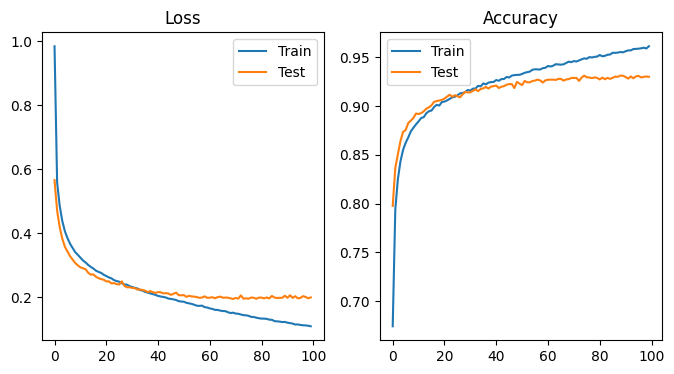

In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(tr_loss_res, label="Train")
plt.plot(te_loss_res, label="Test")
plt.legend()
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(tr_acc_res, label="Train")
plt.plot(te_acc_res, label="Test")
plt.legend()
plt.title("Accuracy")

plt.show();